In [10]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format ='retina'

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from m2py.utils import config
from m2py.utils import utils
from m2py.utils import pre_processing as pre
from m2py.utils import post_processing as post
from m2py.utils import seg_label_utils as slu
from m2py.segmentation import segmentation_gmm as seg_gmm
from m2py.segmentation import segmentation_watershed as seg_water

from PIL import Image

In [11]:
img = Image.open('/Users/wesleytatum/Desktop/20190115/20150115 NBay Control 22-24a - 10x.bmp')

(714, 1588, 3)


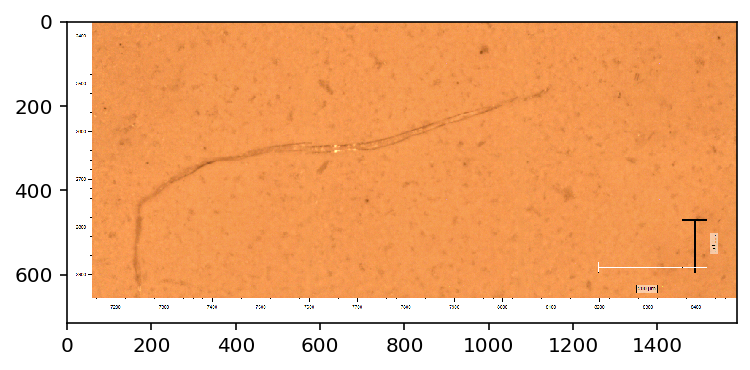

In [12]:
np_img = np.array(img)
print (np_img.shape)
plt.imshow(np_img)

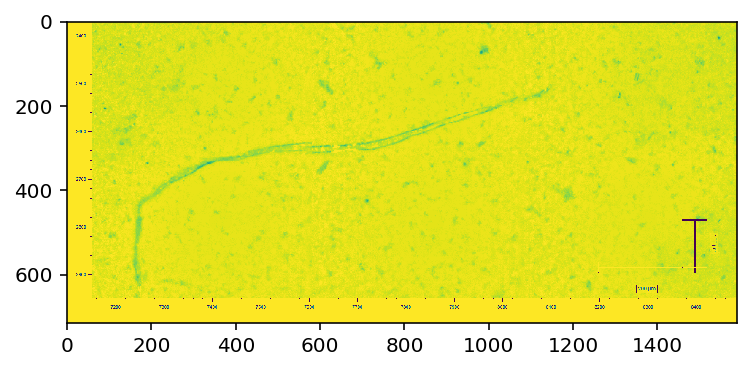

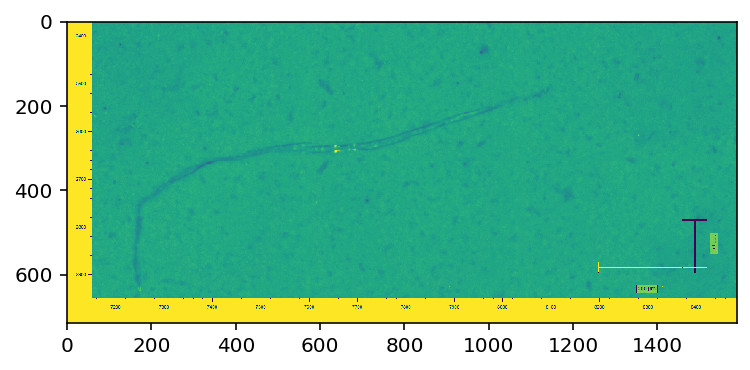

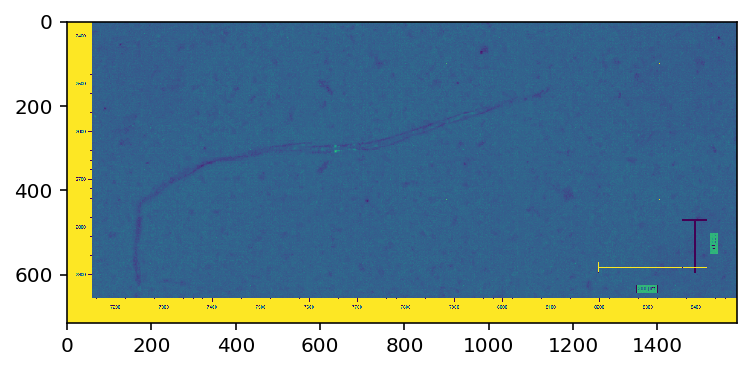

In [13]:
plt.imshow(np_img[:,:,0])
plt.show()
plt.imshow(np_img[:,:,1])
plt.show()
plt.imshow(np_img[:,:,2])
plt.show()

(655, 1528, 3)


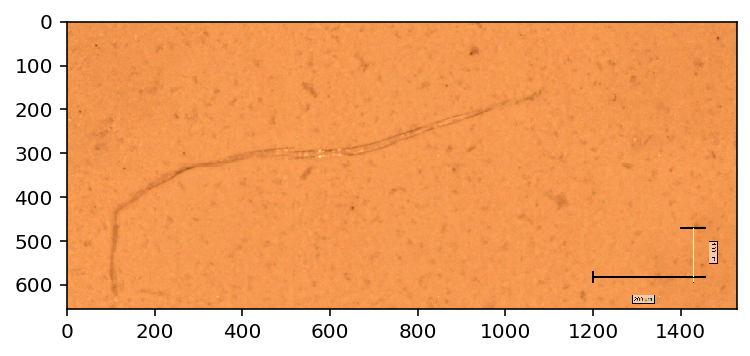

In [14]:
cropped = np_img[:655, 60:, :]
plt.imshow(cropped)

print(cropped.shape)

In [15]:
def m2py_pipeline(dataframe, heightless, outlier_threshold, n_components, padding, embedding_dim, thresh, nonlinear, normalize, zscale, data_type, data_subtype, input_cmap):
    """
    Wrapper function for m2py tools. Allows to include or exclude m2py tools in the order shown in the code.
    
    Args:
    dataframe - np.array(). 3D array of SPM data
    heightless - bool. if 'True', height channel is removed, according to channel labels in config.py
    outlier_threshold
    n_components - int. number specifying the number of Gaussian phase distributions to be identified in dataframe
    padding - int. number specifying the degree of closeness of neighbors to be included in GMM labelling
    embedding_dims - int. number specifying the number of principle components to use in PCA before GMM labelling
    thresh
    nonlinear - bool. if 'True', nonlinear properties are generated prior to analysis. Includes x^2, x^3, abs(x),
                and 1/x
    normalize
    zscale
    data_type
    data_subtype
    input_cmap
                
    Returns:
    outliers - np.array(). 2D array of outliers
    seg1_labels - np.array(). 2D array of GMM labels
    seg2_labels - np.array(). 2D array of clustering labels
    """
  
    fill_zeros_flag = True
    remove_outliers_flag = True
    input_cmap = input_cmap
    
    # Apply frequency removal
    data = pre.apply_frequency_removal(dataframe, data_type)
    
    data_properties = config.data_info[data_type]['properties']

    # Extract outliers
#     outliers = pre.extract_outliers(data, data_type, prop = 'Z-scale', threshold = outlier_threshold, chip_size = 256, stride = 256)
    
    h, w, c = data.shape
    outliers = np.zeros((h, w))
    for prop in data_properties:
        temp_outliers = pre.extract_outliers(data, data_type, prop, 2.5, 500, 30)
        pre.show_outliers(data, data_type, prop, temp_outliers)
    
        outliers = np.logical_or(outliers, temp_outliers)
    
    no_outliers_data = pre.smooth_outliers_from_data(data, outliers)
    
    plt.imshow(outliers)
    plt.show()

    # Show a-priori distributions
    pre.show_property_distributions(data, data_type, outliers)

    c = data.shape[2]
    num_pca_components = min(embedding_dim, c)
    
    # Run GMM segmentation
    seg1 = seg_gmm.SegmenterGMM(n_components = n_components, embedding_dim = num_pca_components, padding = padding,
                                nonlinear = nonlinear, normalize=normalize, zscale=zscale)
        
    gmm_labels = seg1.fit_transform(no_outliers_data, outliers)
    
    h, w, c = no_outliers_data.shape

    pca_components = seg1.get_pca_components(no_outliers_data)
    pca_components = pca_components.reshape(h, w, num_pca_components)
    
    if fill_zeros_flag:
        pca_components = slu.fill_out_zeros(pca_components, outliers)

    elif remove_outliers_flag:
        pca_components = np.ma.masked_where(outliers == 1, pca_components)

    plt.imshow(pca_components[:,:])
    plt.show()


## Persistence Watershed Segmentation clustering

    if thresh != None:

        seg2 = seg_water.SegmenterWatershed()           
        thresh = thresh

        watershed_channel = pca_components

        plt.imshow(watershed_channel, cmap = 'viridis')
        plt.show()

        seg2_labels = seg2.fit_transform(watershed_channel, outliers, thresh)
        seg2_labels = np.ma.masked_where(seg2_labels == 0, seg2_labels)

        seg2_labels = slu.get_significant_labels(seg2_labels, bg_contrast_flag=True)
        post.show_classification(seg2_labels, no_outliers_data, data_type)

## Conected-components clustering
#     else:
#         post_labels = seg1.get_grains(seg1_labels)
#         seg2_labels = slu.get_significant_labels(post_labels, bg_contrast_flag=True)

    post.show_classification(seg2_labels, no_outliers_data, data_type, input_cmap = input_cmap)
    post.show_grain_area_distribution(seg2_labels, data_type, data_subtype)
    
    return outliers, pca_components, seg2_labels

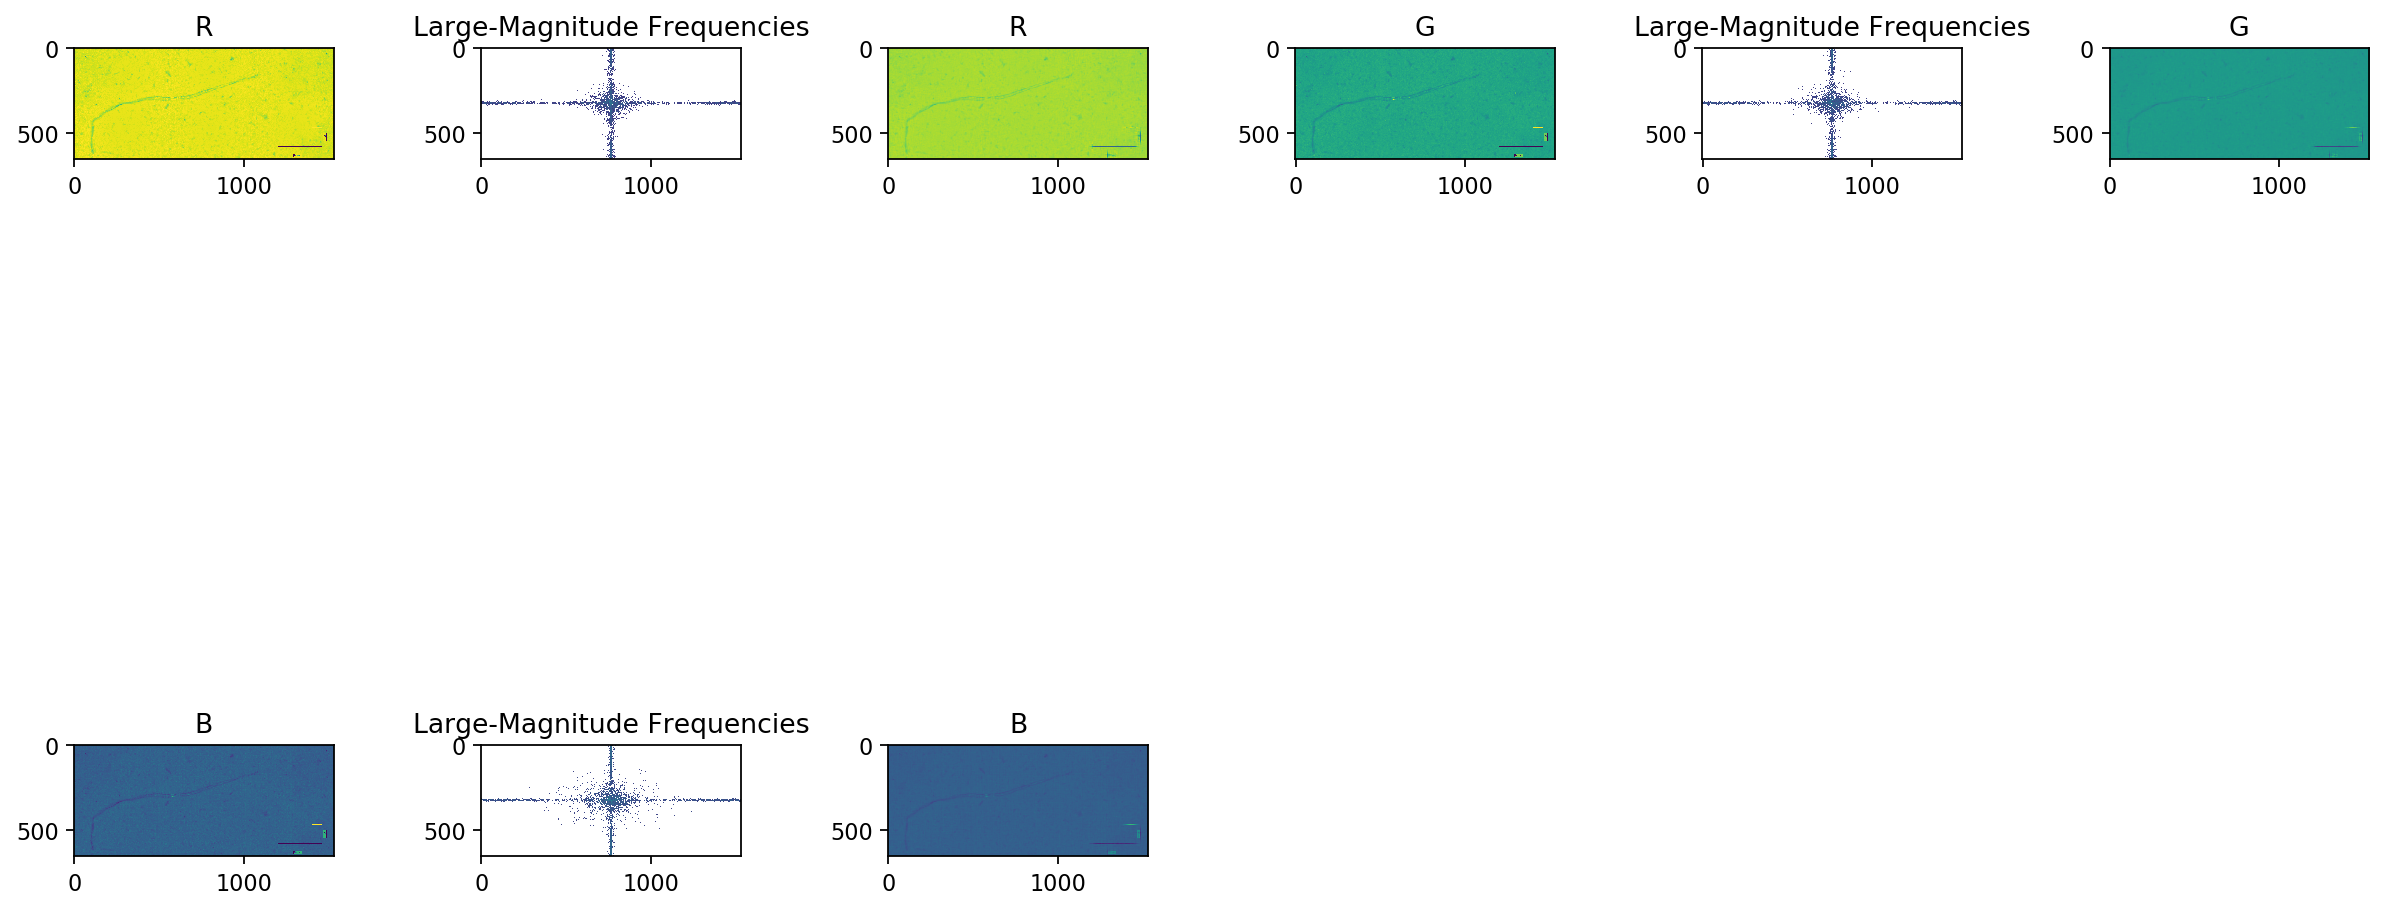

There were 252 chips generated.


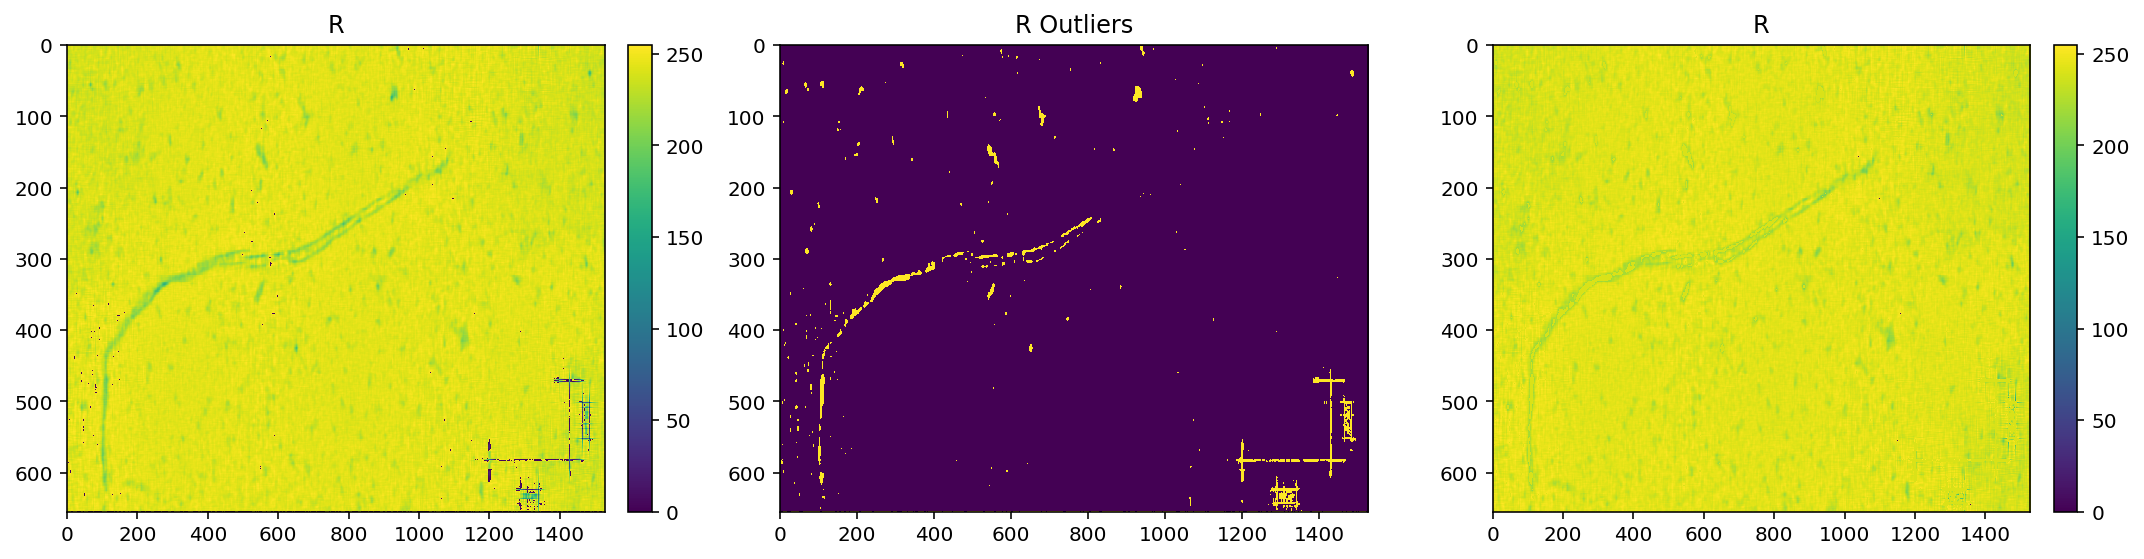

There were 252 chips generated.


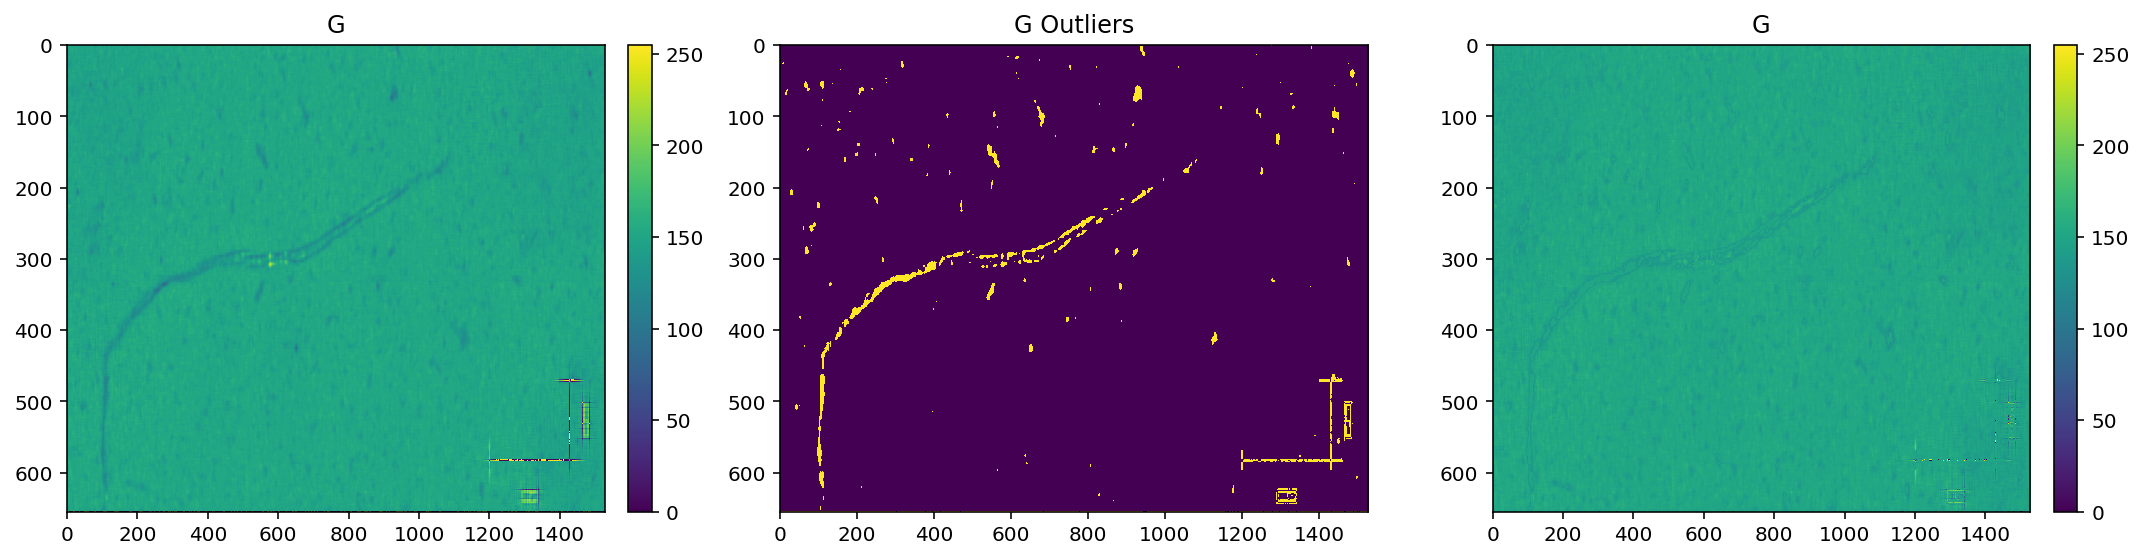

There were 252 chips generated.


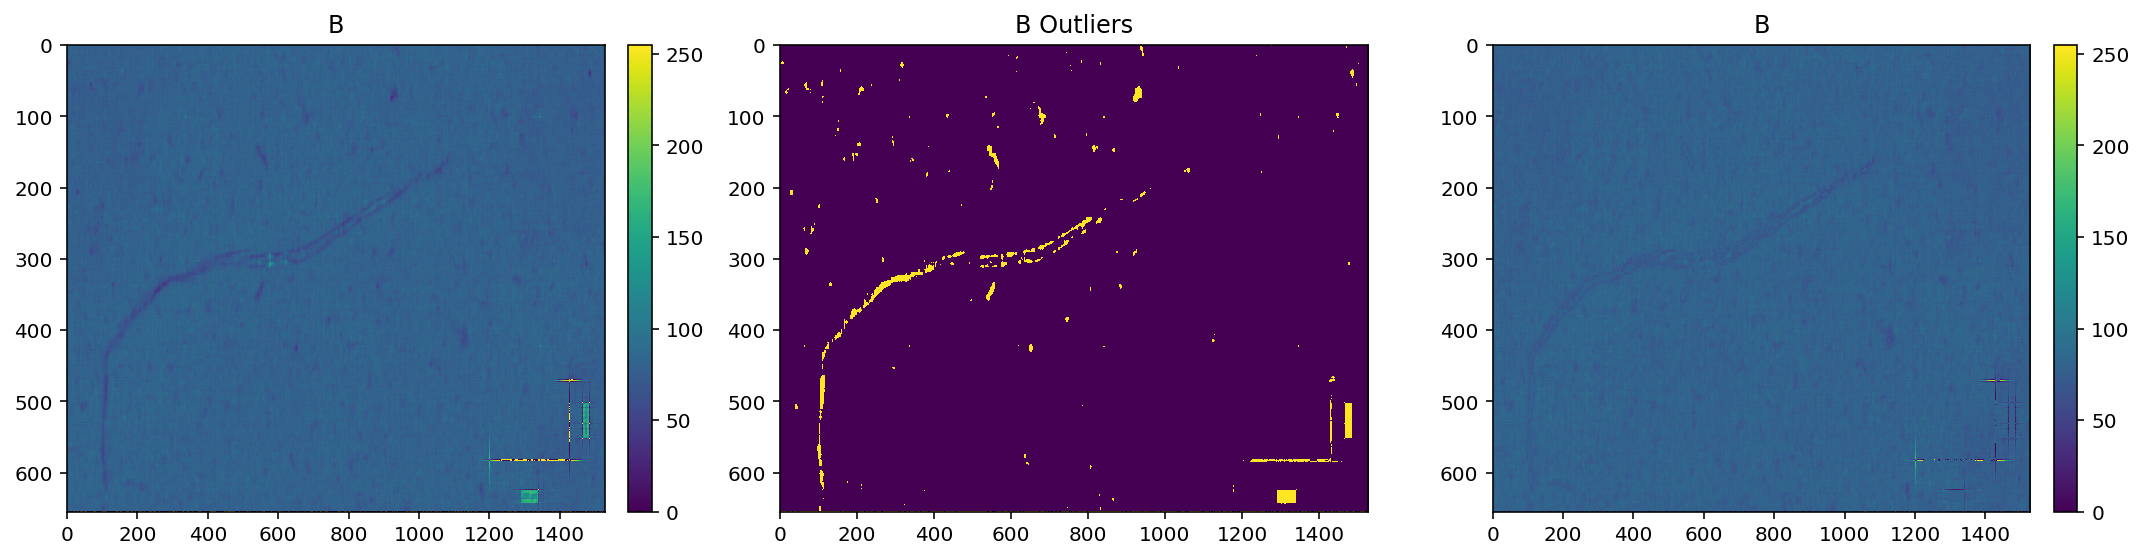

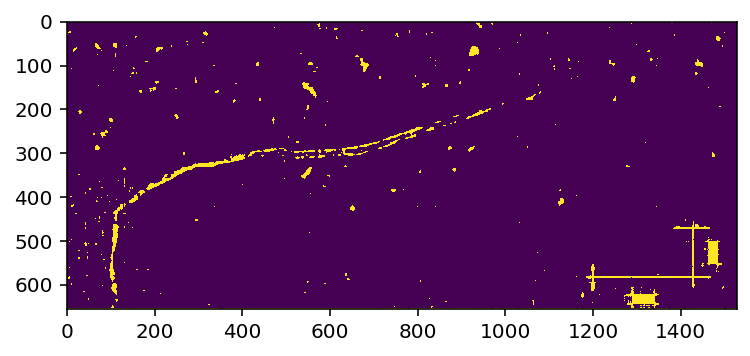

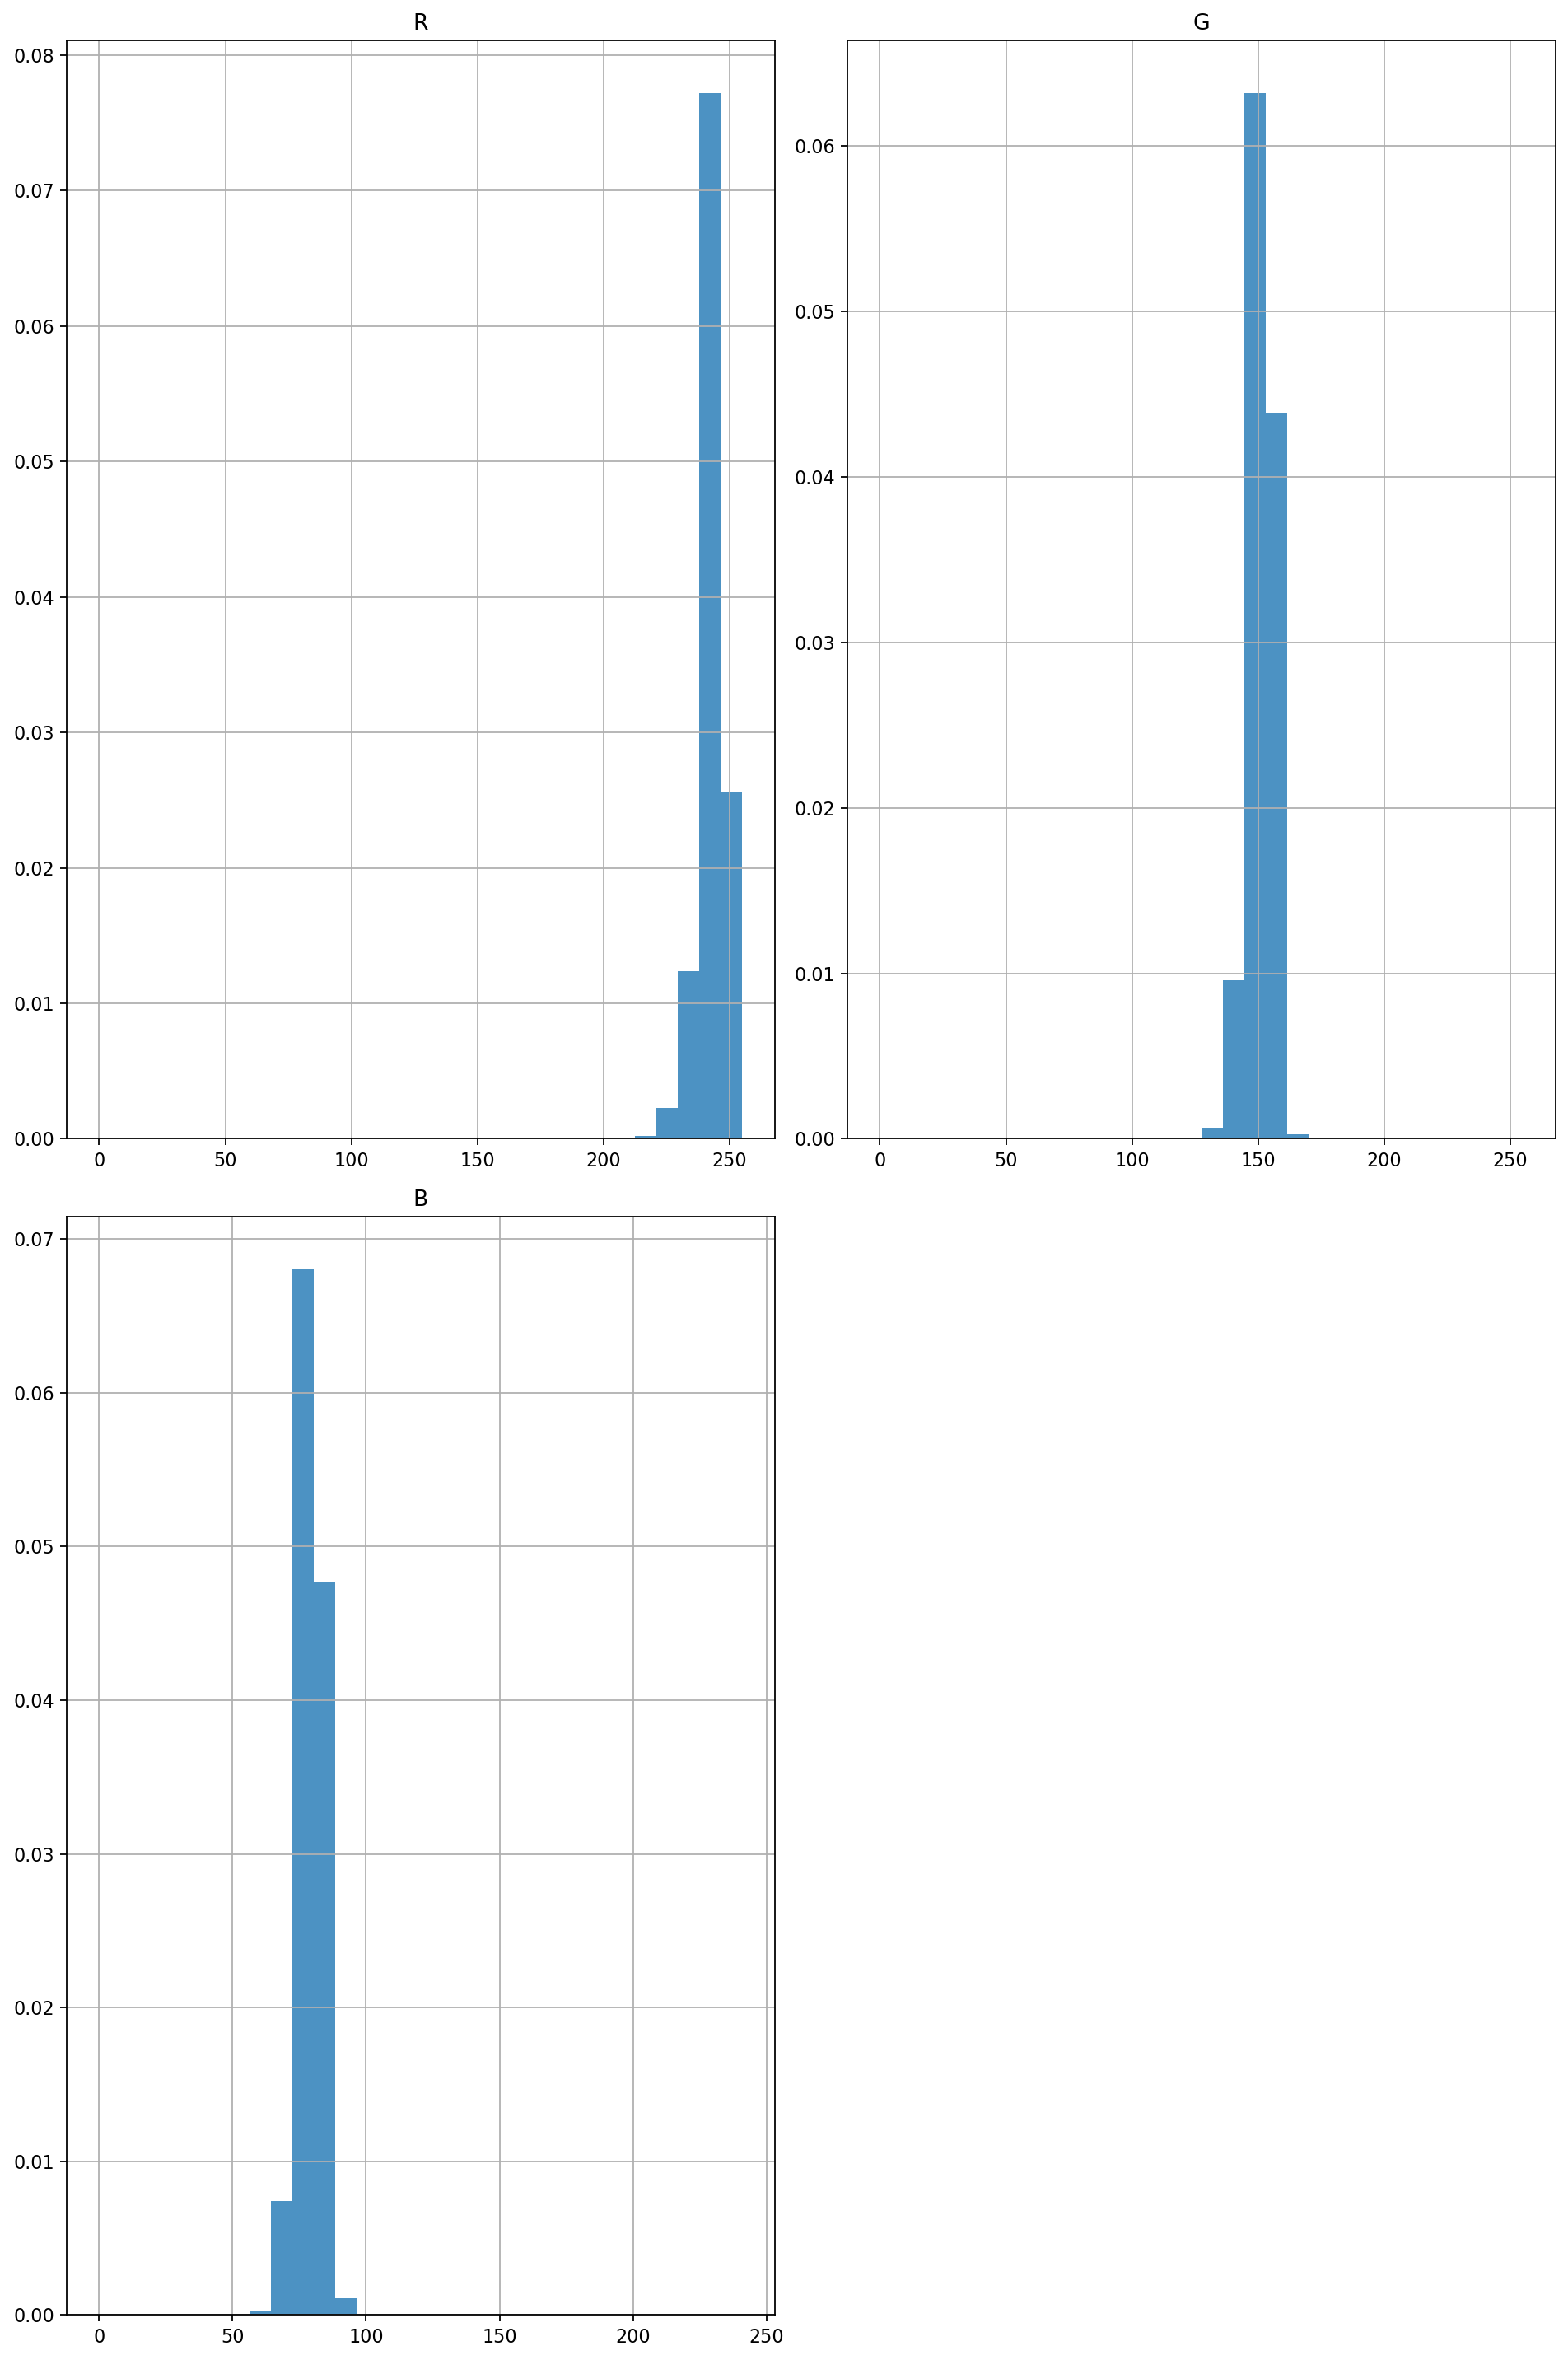

/Users/wesleytatum/Desktop/m2py/m2py_Github/m2py/m2py/segmentation/segmentation_gmm.py:223: RuntimeWarning: divide by zero encountered in true_divide
  reciprocal_data = 1 / data
/Users/wesleytatum/Desktop/m2py/m2py_Github/m2py/m2py/segmentation/segmentation_gmm.py:223: RuntimeWarning: divide by zero encountered in true_divide
  reciprocal_data = 1 / data
/Users/wesleytatum/Desktop/m2py/m2py_Github/m2py/m2py/segmentation/segmentation_gmm.py:223: RuntimeWarning: divide by zero encountered in true_divide
  reciprocal_data = 1 / data


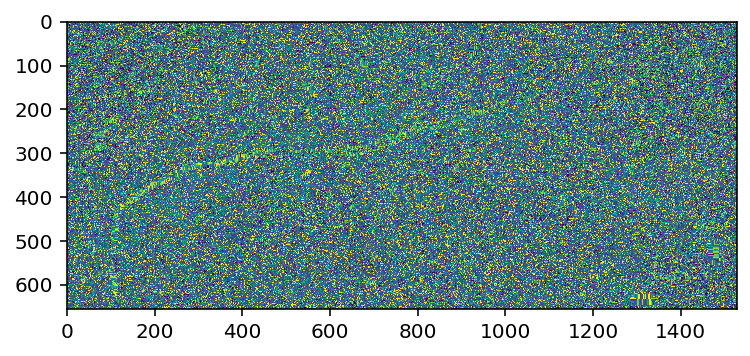

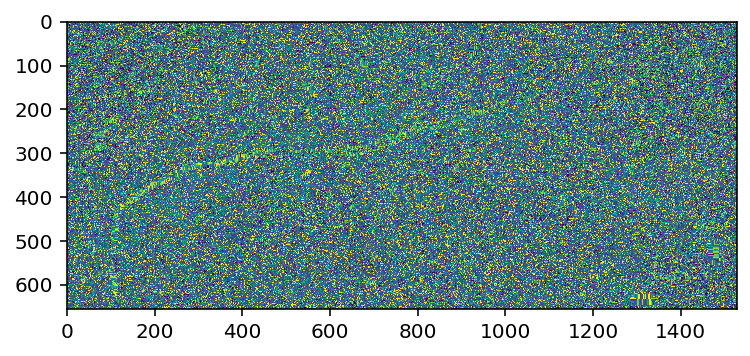

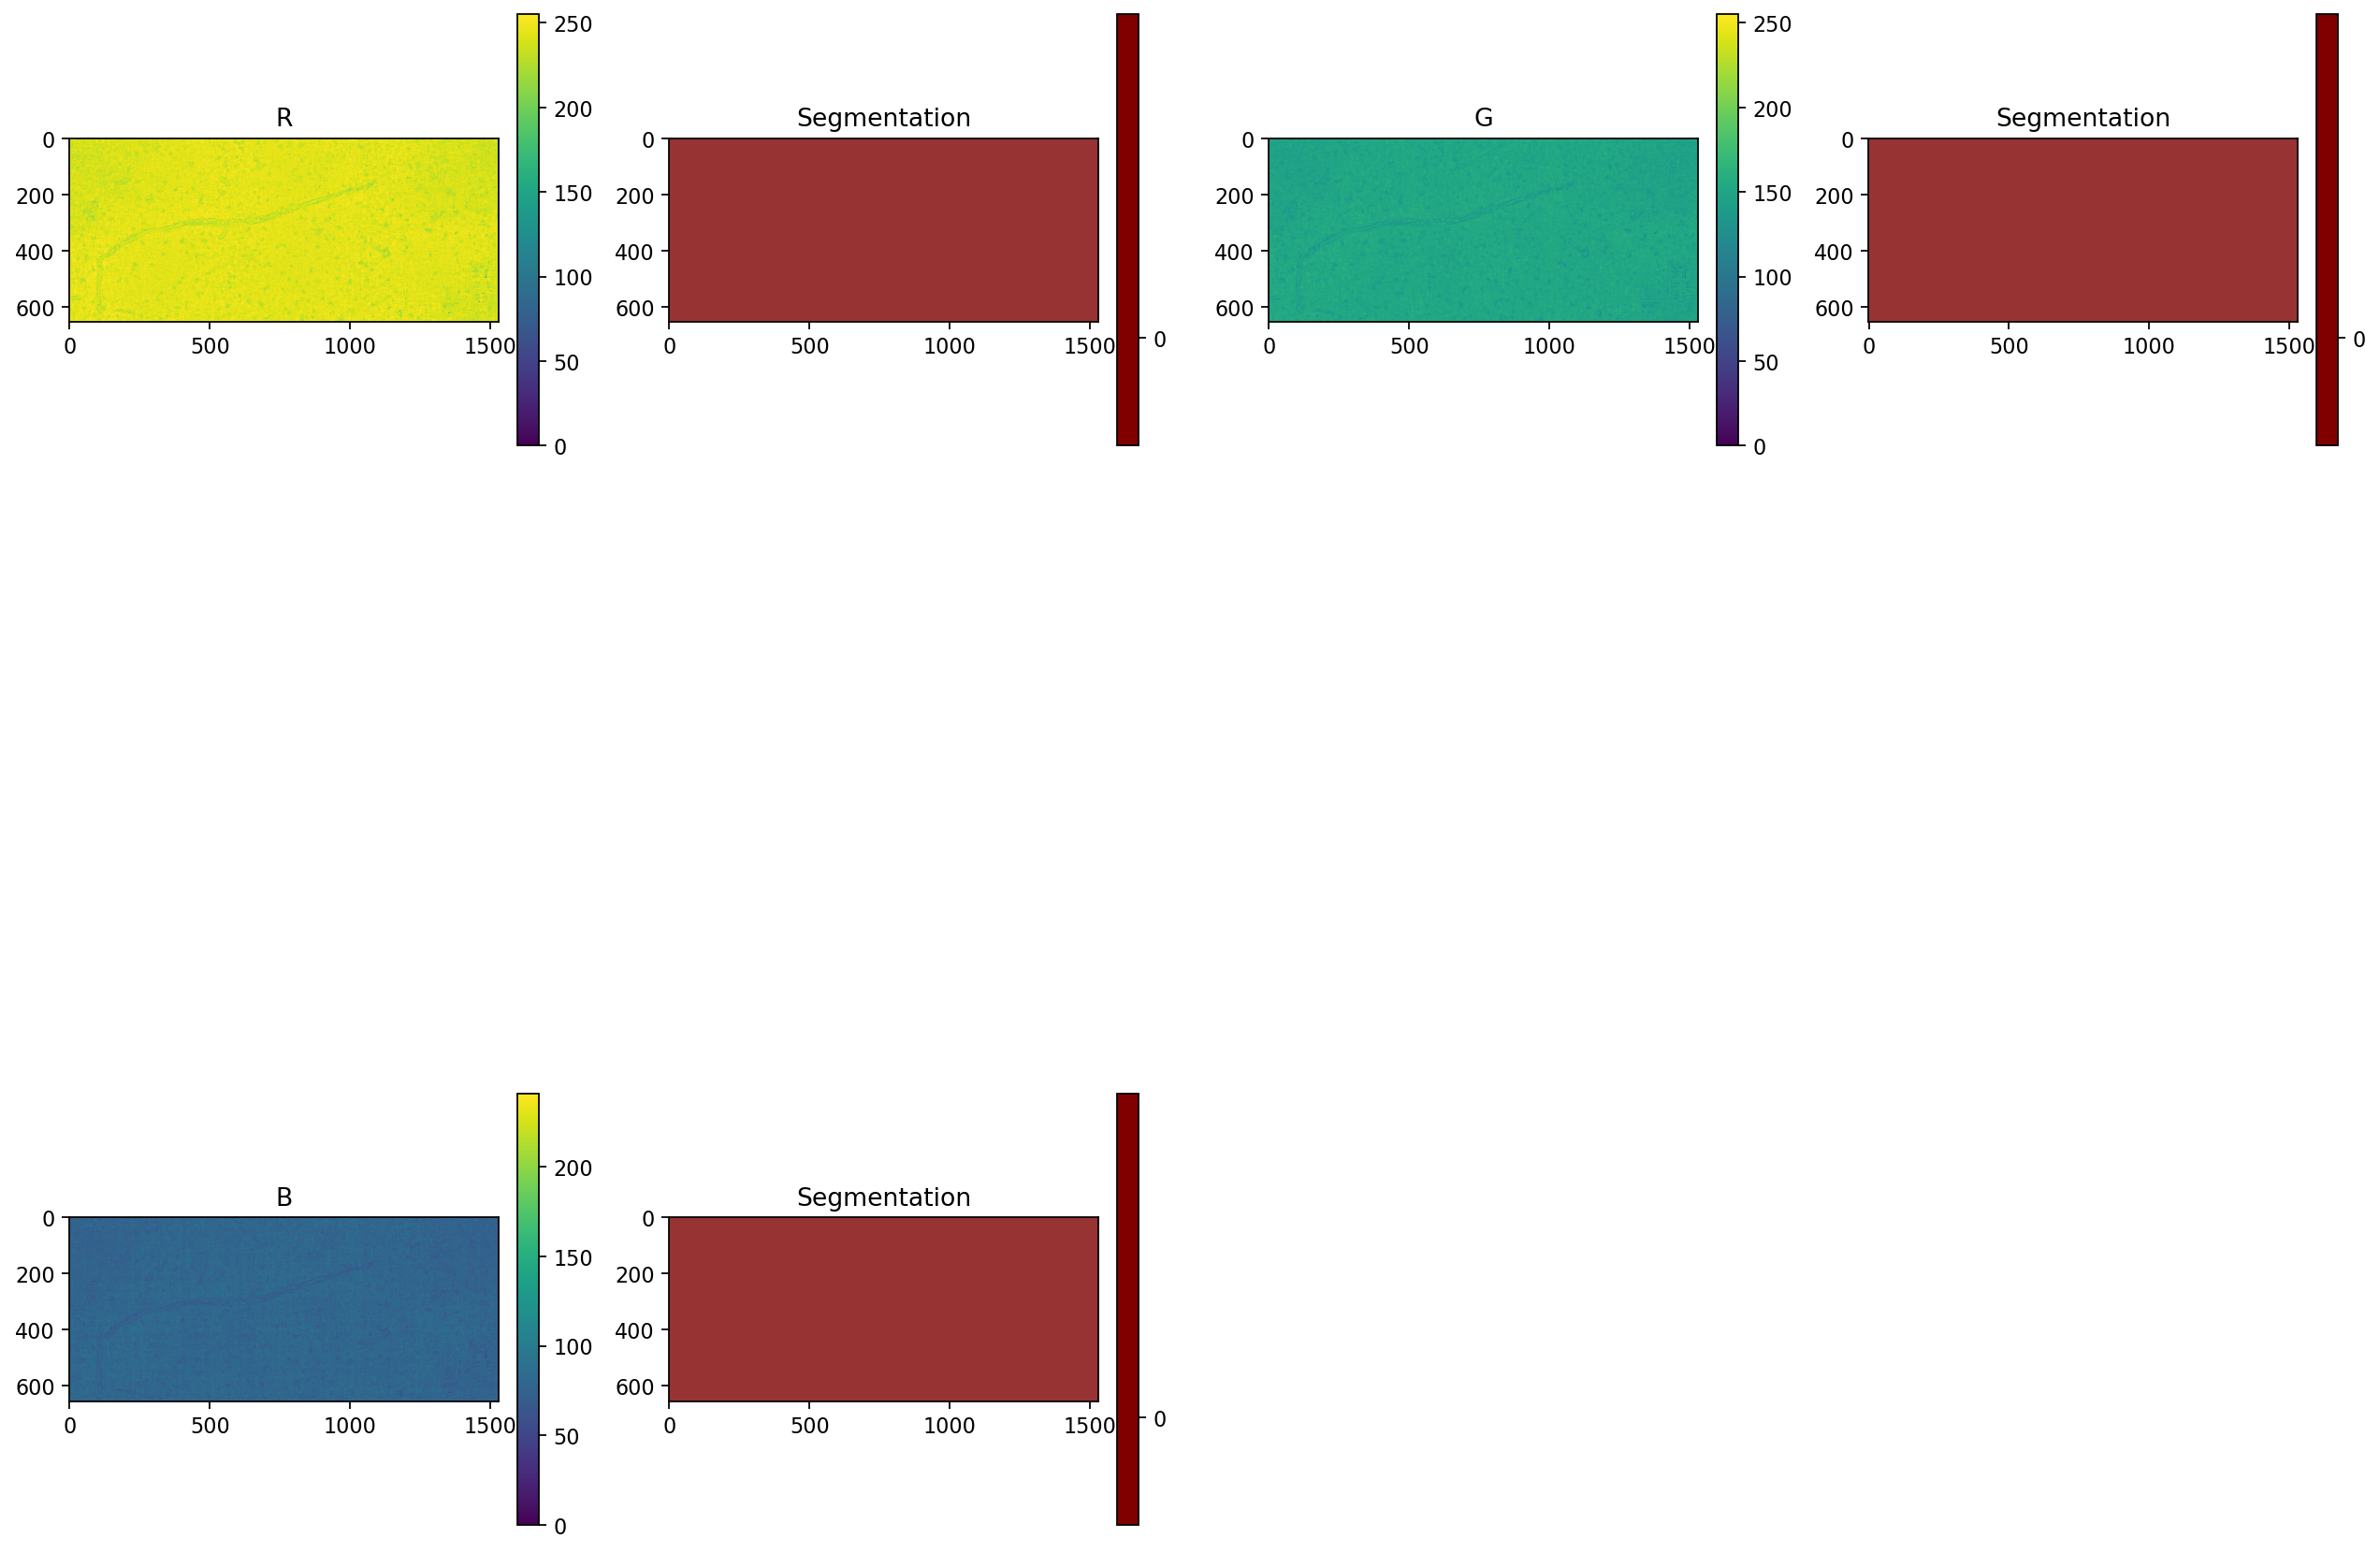

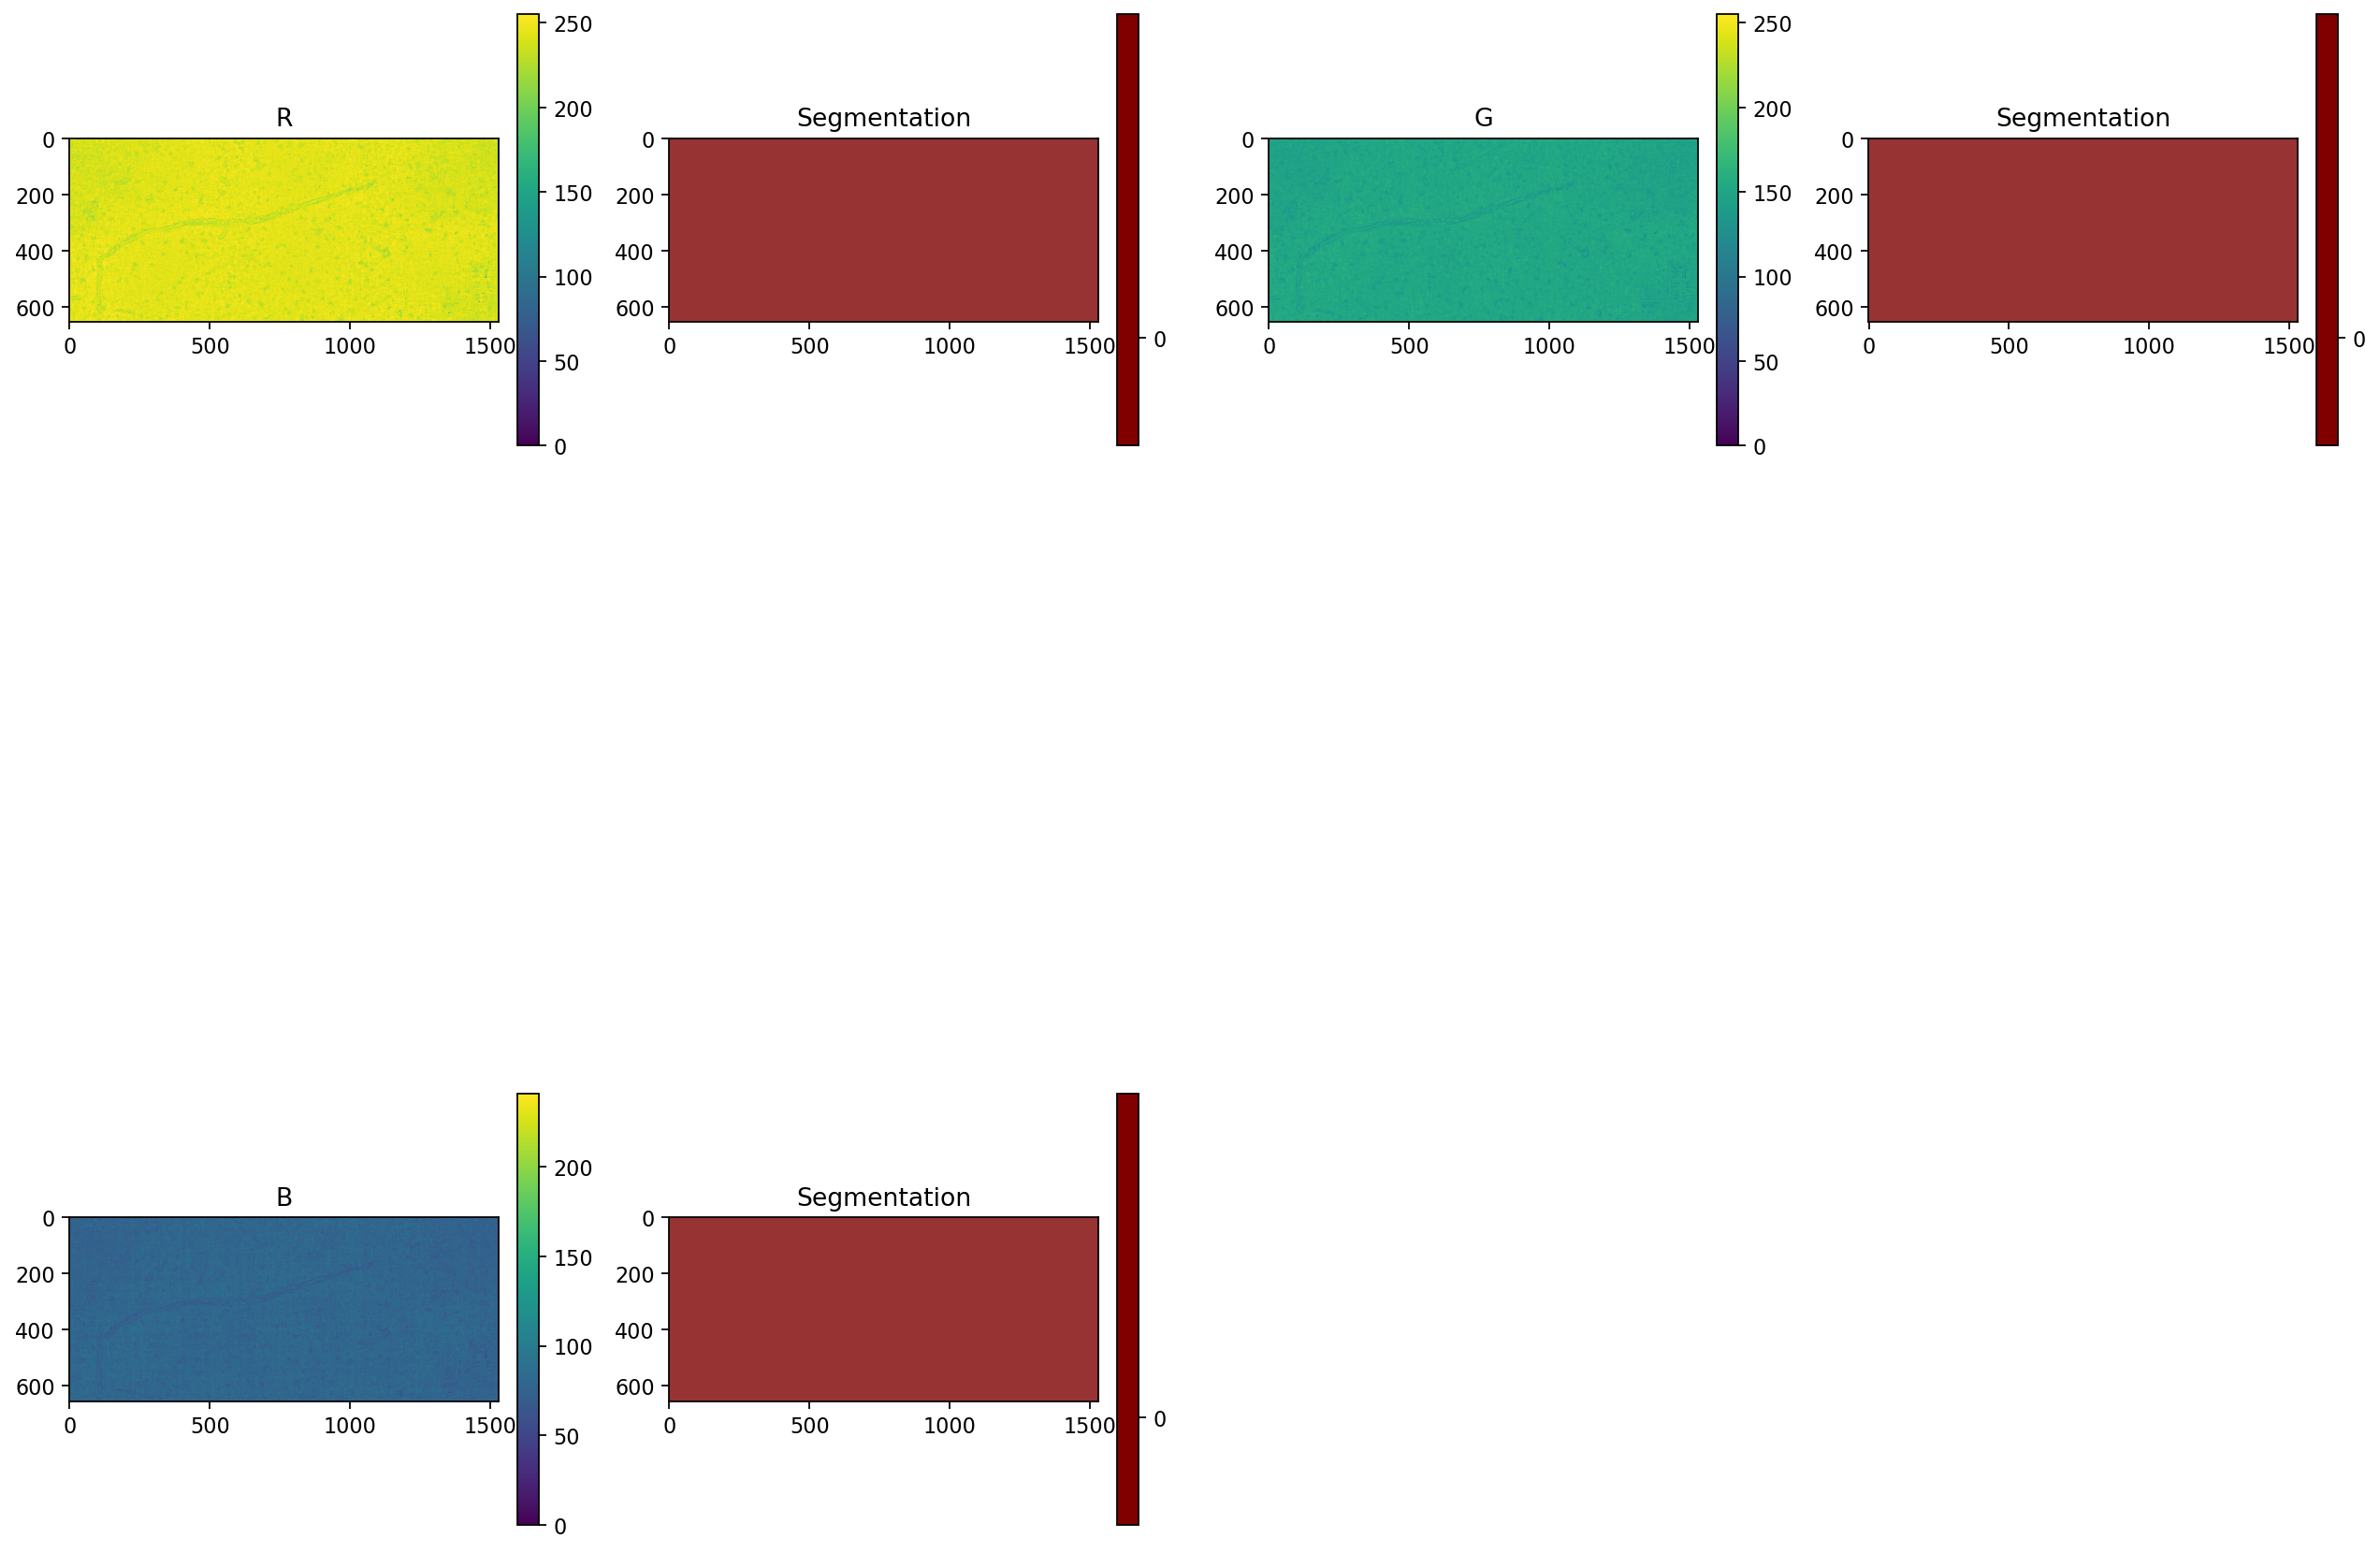

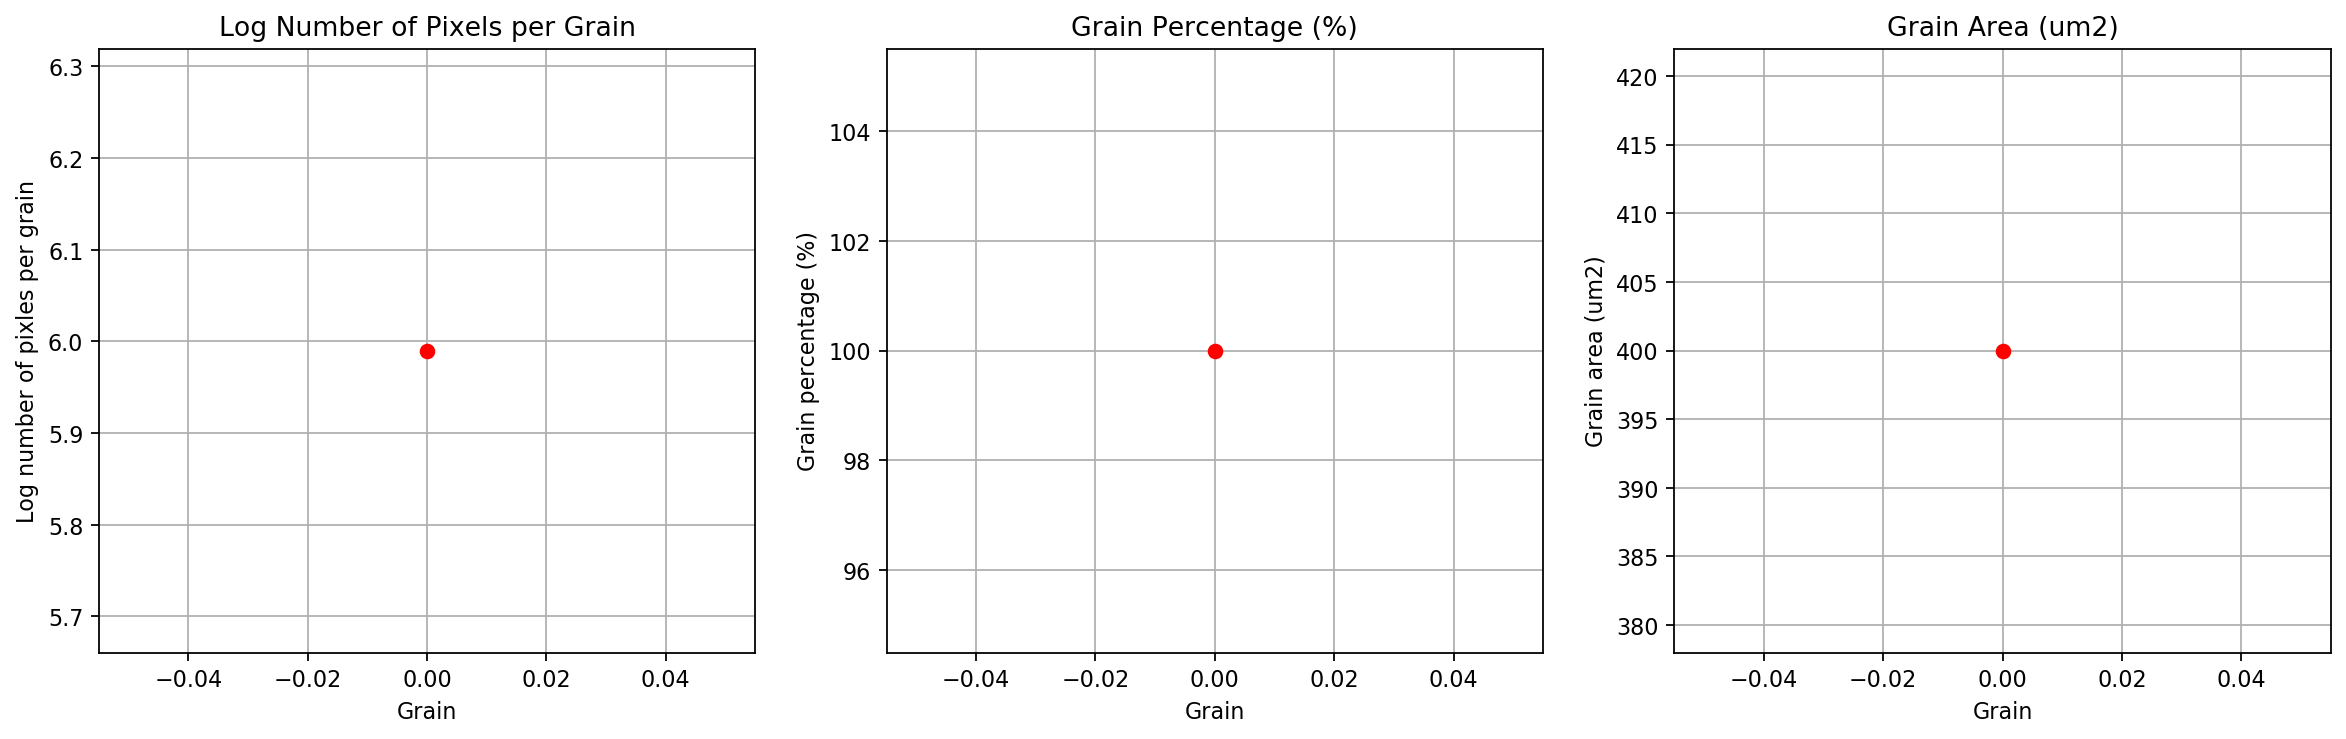

-----------0---------------------------------
--------------------0------------------------
-----------------------------0---------------


In [16]:
ims = [cropped]
n_components = [3]
outlier_threshold = [2.5]
padding = [0]
embedding_dim = [1]
thresh = [0.8]     ## Persistence Watershed Threshold
nonlinear = True
normalize = True
zscale = False
data_type = ['Raman']
data_subtype = ['Microplastics']
input_cmap = ['jet']

seg1_dict = {}    
seg2_dict = {}

h = 0
for h, im in enumerate(ims):
    outliers, seg1_labels, seg2_labels = m2py_pipeline(im, heightless = False,
                                                          n_components = n_components[h],
                                                          outlier_threshold = outlier_threshold[h],
                                                          padding = padding[h],
                                                          embedding_dim = embedding_dim[h],
                                                          thresh = thresh[h],
                                                          nonlinear = nonlinear,
                                                          normalize = normalize,
                                                          zscale = zscale,
                                                          data_type = data_type[h],
                                                          data_subtype = data_subtype[h],
                                                          input_cmap = input_cmap[h])
    
    print (f'-----------{h}---------------------------------')
    print (f'--------------------{h}------------------------')
    print (f'-----------------------------{h}---------------')
    
    seg1_dict[h] = seg1_labels
    seg2_dict[h] = seg2_labels